<a href="https://colab.research.google.com/github/MaramMajed/EmotionDetectionAI/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup and Imports

This section initializes the environment and imports all required libraries used throughout the notebook.


In [71]:
!pip install --quiet tensorflow opencv-python-headless pandas kagglehub

import os
import cv2
import shutil
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [62]:
!pip install --quiet tensorflow opencv-python-headless pandas kagglehub matplotlib

# 2. Dataset Download (FER-2013)

This section loads the required datasets and defines the main data paths used in the project.


In [63]:
import kagglehub

# Download FER-2013 dataset
fer_path = kagglehub.dataset_download("msambare/fer2013")
print("✅ FER2013 downloaded to:", fer_path)
print("📁 Contents:", os.listdir(fer_path))

# Verify dataset structure
train_dir = os.path.join(fer_path, "train")
test_dir = os.path.join(fer_path, "test")

assert os.path.exists(train_dir), "Missing 'train' folder"
assert os.path.exists(test_dir), "Missing 'test' folder"

print("\n📊 Dataset Statistics:")
emotions = os.listdir(train_dir)
for emotion in emotions:
    train_count = len(os.listdir(os.path.join(train_dir, emotion)))
    test_count = len(os.listdir(os.path.join(test_dir, emotion)))
    print(f"{emotion}: {train_count} train, {test_count} test")

Using Colab cache for faster access to the 'fer2013' dataset.
✅ FER2013 downloaded to: /kaggle/input/fer2013
📁 Contents: ['test', 'train']

📊 Dataset Statistics:
surprise: 3171 train, 831 test
fear: 4097 train, 1024 test
angry: 3995 train, 958 test
neutral: 4965 train, 1233 test
sad: 4830 train, 1247 test
disgust: 436 train, 111 test
happy: 7215 train, 1774 test


# 3. Data Preparation and Augmentation


In [64]:
# Image parameters
IMG_SIZE = 48
BATCH_SIZE = 64

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2  # Use 20% of training data for validation
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Get class information
emotion_labels = list(train_generator.class_indices.keys())
num_classes = len(emotion_labels)
print(f"\nEmotion classes: {emotion_labels}")
print(f"Number of classes: {num_classes}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.

Emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


## 4. Visualize Sample Images


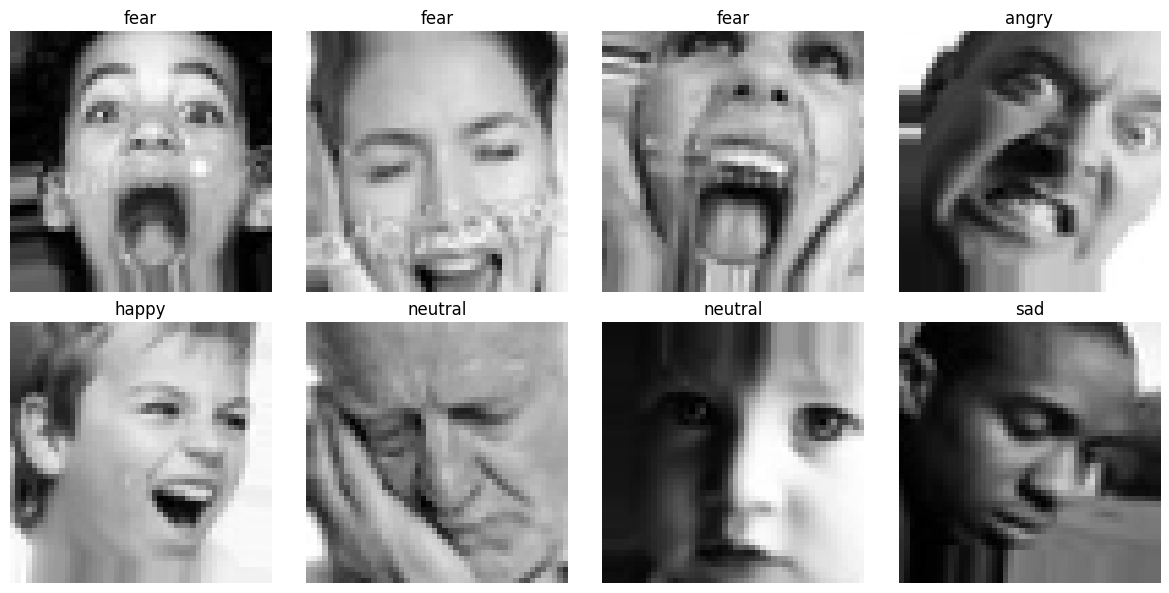

In [65]:
# Visualize some training samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    img_batch, label_batch = next(train_generator)
    img = img_batch[0].squeeze()
    label_idx = np.argmax(label_batch[0])

    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(emotion_labels[label_idx])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Reset generator
train_generator.reset()

# 5. CNN Model Architecture

This section defines the Convolutional Neural Network architecture used for facial expression recognition.


In [69]:
def create_model(num_classes):
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile model
model = create_model(num_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,003,143 (22.90 MB)

 Trainable params: 5,999,815 (22.89 MB)

 Non-trainable params: 3,328 (13.00 KB)

# 6. Model Compilation

This section configures the training process by specifying the optimizer, loss function, and evaluation metrics.


In [72]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
EPOCHS = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n✅ Training completed!")

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 130s 316ms/step - accuracy: 0.1882 - loss: 2.5197 - val_accuracy: 0.2655 - val_loss: 1.8579 - learning_rate: 0.0010
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.2991 - loss: 1.8419 - val_accuracy: 0.3405 - val_loss: 1.6505 - learning_rate: 0.0010
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.3516 - loss: 1.6585 - val_accuracy: 0.3593 - val_loss: 1.5996 - learning_rate: 0.0010
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.4311 - loss: 1.4803 - val_accuracy: 0.4851 - val_loss: 1.3513 - learning_rate: 0.0010
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.4830 - loss: 1.3499 - val_accuracy: 0.4801 - val_loss: 1.4119 - learning_rate: 0.0010
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 99ms/step - accuracy: 0.5154 - loss: 1.2785 - val_accuracy: 0.5149 - val_loss: 1.2937 - learning_rate: 0.0010
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.5357 - loss: 1.2

# 7. Visualize Training History


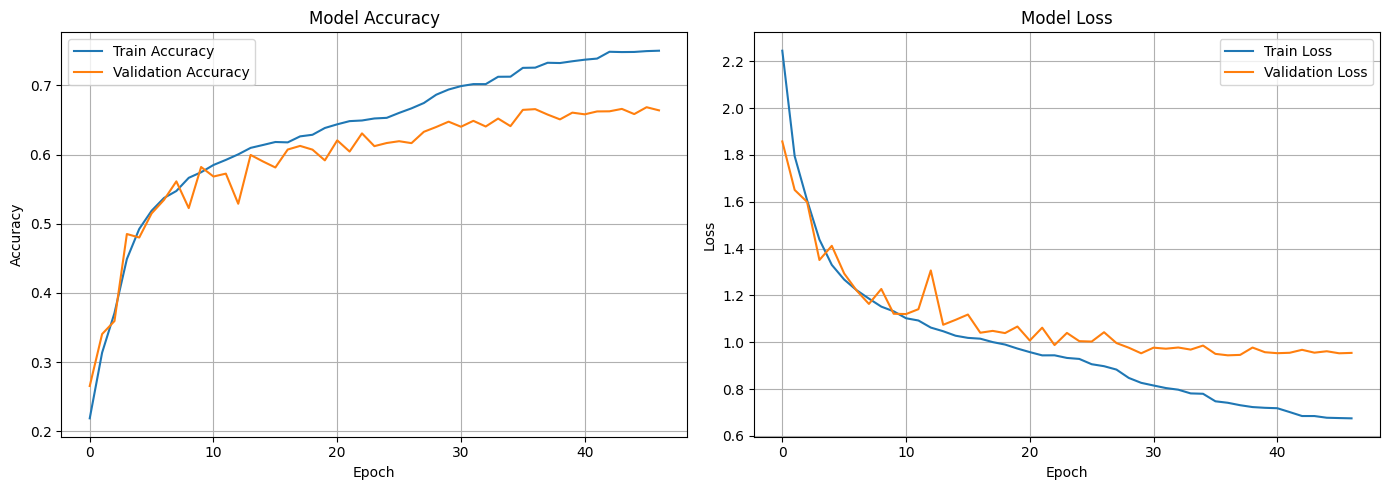


Best Validation Accuracy: 0.6684 at epoch 46


In [73]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print best results
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f} at epoch {best_epoch + 1}")

## 8. Evaluate on Test Set

In [74]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n📊 Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6298 - loss: 1.0242

📊 Test Results:
Test Loss: 0.9348
Test Accuracy: 0.6658
Test Accuracy: 66.58%


## 9. Confusion Matrix and Classification Report

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step


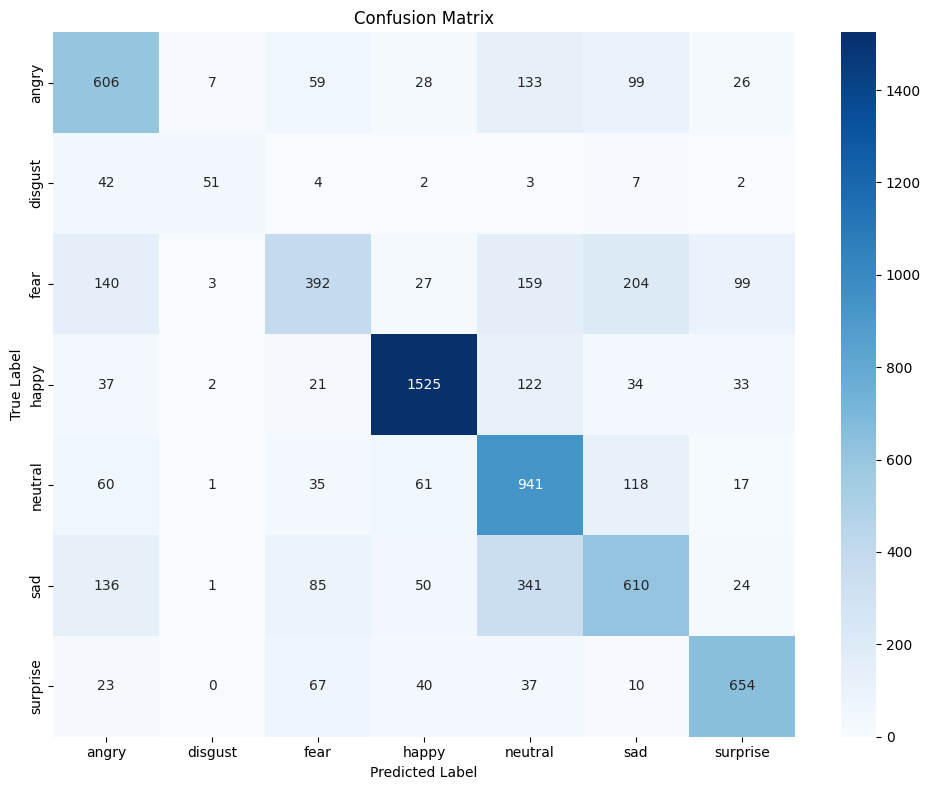


📋 Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.63      0.61       958
     disgust       0.78      0.46      0.58       111
        fear       0.59      0.38      0.46      1024
       happy       0.88      0.86      0.87      1774
     neutral       0.54      0.76      0.63      1233
         sad       0.56      0.49      0.52      1247
    surprise       0.76      0.79      0.78       831

    accuracy                           0.67      7178
   macro avg       0.67      0.62      0.64      7178
weighted avg       0.67      0.67      0.66      7178



In [75]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

## 10. Save the Model

In [81]:
# Save model
model.save('emotion_recognition_model.keras')
print("✅ Model saved as 'emotion_recognition_model.h5'")

# Save model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save weights separately
model.save_weights("model_weights.weights.h5")
print("✅ Model weights saved as 'model_weights.weights.h5'")

✅ Model saved as 'emotion_recognition_model.h5'
✅ Model weights saved as 'model_weights.weights.h5'


## 11. Prediction Function for New Images

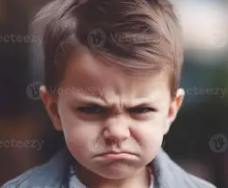

Upload an image to test emotion recognition:


Saving Screenshot 2026-01-12 102545.png to Screenshot 2026-01-12 102545 (1).png

Processing: Screenshot 2026-01-12 102545 (1).png


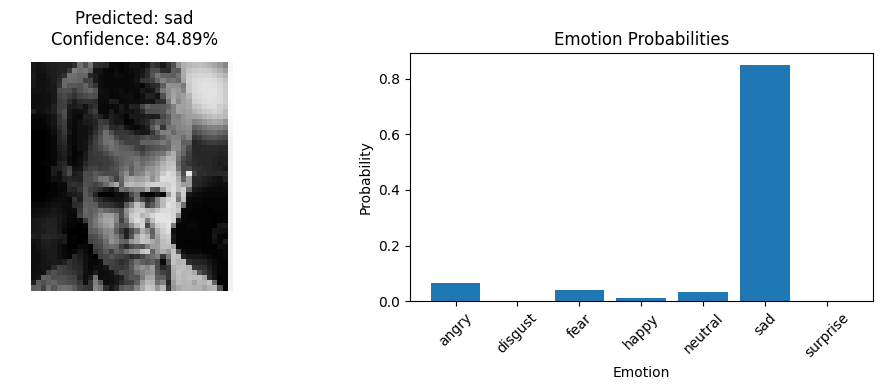

Predicted emotion: sad
Confidence: 84.89%


In [79]:
# For Google Colab - upload and test
from google.colab import files

print("Upload an image to test emotion recognition:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nProcessing: {filename}")
    predicted_emotion, confidence = predict_emotion(filename, model, emotion_labels)
    print(f"Predicted emotion: {predicted_emotion}")
    print(f"Confidence: {confidence:.2%}")